In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1


In [2]:
from configs.wavenet_biogas import hparams
hparams = hparams()
print(hparams)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[('batch_size', 800), ('datagen', 'biogas'), ('dilation_channels', 16), ('dilations', [1, 2, 4, 8, 16, 32, 64]), ('filter_width', 2), ('in_seq_len', 258), ('initial_filter_width', 2), ('input_channels', 1), ('input_dim', 1), ('lambd', 1e-10), ('learning_rate', 0.01), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.995), ('norm_epsilon', 1e-12), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('quantization_channels', 100), ('residual_channels', 16), ('sample_rate', 24), ('scalar_input', False), ('skip_channels', 32), ('test_split', 0.1), ('train_split', 0.8), ('use_biases', True), ('val_split', 0.1)]


In [96]:
hparams.num_layers  = 3
hparams.quantization_channels = 100
hparams.embd_pdrop  = 0.2
hparams.attn_pdrop  = 0.2
hparams.resid_pdrop = 0.2
hparams.num_states  = 64
hparams.num_heads   = 4
hparams.learning_rate = 1e-4
hparams.batch_size = 100
hparams.in_seq_len = 24
hparams.out_seq_len = 24 * 5
hparams.lambd=1e-6

In [97]:
from data_loader.sin import *
dataset, dataset_val, dataset_test = load_data(hparams, mode='fixed_frequency', normalise='random_scale_and_offset')
target, inp, mask, x_max = next(iter(dataset))

Added x, y data
Added y_mask data
Added x_max data


In [5]:
def jitter(inp, target):
    delta = tf.random.uniform((inp.shape[0],1,1), -0.05, 0.05)
    inp = inp + delta
    target = target + delta

    for _ in range(3):
        delta = tf.reduce_min(tf.minimum(tf.concat([inp, target], 1),0), axis=1, keepdims=True)
        inp = inp - 2 * delta
        target = target - 2 * delta

        delta = tf.reduce_max(tf.maximum(tf.concat([inp, target], 1) - 1,0), axis=1, keepdims=True)
        inp = inp - 2 * delta
        target = target - 2 * delta
        
    return inp, target

def create_gaussian_labels(inp):
    labels = tf.cast(hparams.quantization_channels * (inp), tf.int32)
    labels = tf.one_hot(labels, (hparams.quantization_channels+1))
    labels = tf.transpose(labels, [0,1,3,2])
    labels = gaussian_filter(labels)
    labels = tf.squeeze(labels)
    return labels

In [6]:
class GPT(tf.keras.Model):
    '''
    https://github.com/NVIDIA/nv-wavenet/blob/master/pytorch/wavenet.py
    '''
    def __init__(self, params, condition_model=False):
        super(GPT, self).__init__()

        self.num_layers            = params.num_layers
        self.quantization_channels = params.quantization_channels
        self.embd_pdrop            = params.embd_pdrop
        self.attn_pdrop            = params.attn_pdrop
        self.resid_pdrop           = params.resid_pdrop
        self.num_states            = params.num_states
        self.num_heads             = params.num_heads
        
        self.we = tf.get_variable('embedding', [self.quantization_channels + 1, self.num_states],
                                  initializer=tf.random_normal_initializer(stddev=0.02))
        #self.embed = tf.keras.layers.Embedding(self.quantization_channels + 1, self.num_states,
                                               #name='embedding')
            # Need an extra channel to create enough buckets e.g. [0-100] Needs 101 channels

        self.attn_layers = []
        self.norm_layers = []
        self.mlp_layers  = []
        for ix in range(self.num_layers):
            self._block(ix)

    ##########################################
    # Build functions
    ##########################################
    def _block(self, ix, scale=False):
        a = self._attn(ix, self.num_states, self.num_heads)
        self.attn_layers.append(a)

        g1 = tf.get_variable('g1_%i' % ix, [self.num_states], initializer=tf.constant_initializer(1))
        b1 = tf.get_variable('b1_%i' % ix, [self.num_states], initializer=tf.constant_initializer(0))
        g2 = tf.get_variable('g2_%i' % ix, [self.num_states], initializer=tf.constant_initializer(1))
        b2 = tf.get_variable('b2_%i' % ix, [self.num_states], initializer=tf.constant_initializer(0))
        self.norm_layers.append({'g1': g1, 'b1': b1, 'g2': g2, 'b2': b2})
        
        m_fc   = tf.keras.layers.Conv1D(self.num_states * 4, 1, name='mlp_fc_%i' % ix, activation='relu')
        m_proj = tf.keras.layers.Conv1D(self.num_states,     1, name='mlp_proj_%i' % ix)
        self.mlp_layers.append({'fc': m_fc, 'proj': m_proj})

        return

    def _attn(self, i, n_state, n_head):
        assert n_state%n_head==0
        layer = {}
        layer['conv']  = tf.keras.layers.Conv1D(n_state*3, kernel_size=1, padding='valid', name='conv_attn_%i' % i)
        layer['resid'] = tf.keras.layers.Conv1D(n_state,   kernel_size=1, padding='valid', name='proj_attn_%i' % i)
        return layer
            
    ##########################################
    # Call functions
    ##########################################
    def embed(self, x):
        e = tf.cast(self.quantization_channels * x, tf.int32)
        e = tf.gather(self.we, e)
        e = tf.reduce_sum(e, 2)
        return e
    
    def block(self, x, i, train=False, scale=False):
        a = self.attn(x, i, train=train)
        n = self.norm(x+a, g=self.norm_layers[i]['g1'], b=self.norm_layers[i]['b1'])
        m = self.mlp(n, i)
        h = self.norm(n+m, g=self.norm_layers[i]['g2'], b=self.norm_layers[i]['b2'])
        return h

    def attn(self, x, i, train=False):
        nm, nx, nf = x.shape.as_list() # Batch size, batch length, num filters
        nh = self.num_heads            # Num heads
        ns = nf // nh                  # Num split filters

        # Extract keys, queries and values
        c = self.attn_layers[i]['conv'](x)
        k, q, v = tf.split(c, 3, 2)
        k = tf.transpose(tf.reshape(k, [nm, nx, nh, ns]), [0, 2, 3, 1])
        q = tf.transpose(tf.reshape(q, [nm, nx, nh, ns]), [0, 2, 1, 3])
        v = tf.transpose(tf.reshape(v, [nm, nx, nh, ns]), [0, 2, 1, 3])
        
        # Attention Calculation
        w = tf.matmul(q, k)
                         
        # Mask Attention
        b = tf.matrix_band_part(tf.ones([nx, nx]), -1, 0)
        b = tf.reshape(b, [1, 1, nx, nx])
        w = w*b + -1e9*(1-b)

        # Apply Attention Weights
        w = tf.nn.softmax(w)
        if train: w = tf.nn.dropout(w, rate=self.attn_pdrop)

        a = tf.matmul(w, v)
        a = tf.reshape(a, [nm, nx, nf])
        
        a = self.attn_layers[i]['resid'](a)
        if train: a = tf.nn.dropout(a, rate=self.resid_pdrop)

        return a
    
    def norm(self, x, g=None, b=None, e=1e-5, axis=[1]):
        u = tf.reduce_mean(x, axis=axis, keep_dims=True)
        s = tf.reduce_mean(tf.square(x-u), axis=axis, keep_dims=True)
        x = (x - u) * tf.rsqrt(s + e)
        if g is not None and b is not None:
            x = x*g + b
        return x
    
    def mlp(self, x, i, train=False):
        x = self.mlp_layers[i]['fc'](x)
        x = self.mlp_layers[i]['proj'](x)
        if train: x = tf.nn.dropout(x, rate=self.resid_pdrop)
        return x
            
    def call(self, inp, mask=None, train=False):
        
        assert(0 <= np.max(inp) <= 1.)
        inp = self.embed(inp)
        if train: inp = tf.nn.dropout(inp, rate=self.embd_pdrop)

        for i in range(self.num_layers):
            inp = self.block(inp, i, train=train)
        
        nm, nx, nf = inp.shape.as_list()
        inp = tf.reshape(inp[:, :-1], [-1, self.num_states])
        inp = tf.matmul(inp, self.we, transpose_b=True)
        inp = tf.reshape(inp, [nm, nx-1, -1])
        
        return inp

In [13]:
model = GPT(hparams)
#optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)
optimizer = tf.train.RMSPropOptimizer(hparams.learning_rate)
if True:
    gaussian_filter = tf.keras.layers.Conv2D(1, kernel_size=(1,5), padding='same', use_bias=False,
                        kernel_initializer = tf.initializers.constant([[.01, .05, .88, .05, .01]]))
elif True:
    gaussian_filter = tf.keras.layers.Conv2D(1, kernel_size=(1,3), padding='same', use_bias=False,
                            kernel_initializer = tf.initializers.constant([[.01, .98, .01]]))

In [99]:
# Gaussian dilation embedded label
for epoch in range(10000):
    if epoch % 10 == 0:
        dataset, _, _ = load_data(hparams, normalise='random_scale_and_offset', isVerbose=False)
    losses = []
    for target, inp, mask, x_max in iter(dataset):
        with tf.GradientTape() as tape:
            pred = model(inp, train=True)

            labels=tf.cast(hparams.quantization_channels * inp[:, 1:, 0], tf.int32)
            ce_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=labels)
            ce_loss = tf.reduce_mean(ce_loss)
            
            l2_loss = tf.reduce_sum([tf.reduce_sum(var ** 2) * (1 if var.name.find('bias') == -1 else 0)\
                                     for var in model.trainable_variables]) * hparams.lambd
            
            loss = tf.reduce_sum([ce_loss, l2_loss])
            
        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)
    
    #optimizer._learning_rate *= 0.999
    if epoch % 10 == 0:
        print(epoch, ': ', np.round(np.dstack(losses).mean(), 3), np.round(ce_loss, 3), np.round(l2_loss,3))

0 :  2.142 2.14 0.002
10 :  1.956 1.954 0.002
20 :  1.987 1.985 0.002
30 :  1.844 1.842 0.002
40 :  1.703 1.701 0.002
50 :  1.683 1.681 0.002
60 :  1.642 1.64 0.002
70 :  1.625 1.623 0.002
80 :  1.558 1.556 0.002
90 :  1.567 1.565 0.002
100 :  1.647 1.645 0.002
110 :  1.586 1.584 0.002
120 :  1.495 1.493 0.002
130 :  1.498 1.496 0.002
140 :  1.526 1.524 0.002
150 :  1.485 1.483 0.002
160 :  1.501 1.499 0.002
170 :  1.52 1.518 0.002
180 :  1.458 1.456 0.002
190 :  1.592 1.59 0.002
200 :  1.526 1.524 0.002
210 :  1.423 1.421 0.002
220 :  1.421 1.419 0.002
230 :  1.422 1.42 0.002
240 :  1.462 1.46 0.002
250 :  1.404 1.402 0.002
260 :  1.473 1.471 0.002
270 :  1.439 1.437 0.002
280 :  1.293 1.291 0.002
290 :  1.403 1.401 0.002
300 :  1.418 1.416 0.002
310 :  1.48 1.478 0.002
320 :  1.461 1.459 0.002
330 :  1.446 1.444 0.002
340 :  1.46 1.458 0.002
350 :  1.419 1.417 0.002
360 :  1.465 1.463 0.002
370 :  1.48 1.478 0.002
380 :  1.321 1.319 0.002
390 :  1.455 1.453 0.002
400 :  1.394 1.392 0

3220 :  1.037 1.035 0.002
3230 :  1.102 1.1 0.002
3240 :  1.09 1.088 0.002
3250 :  1.146 1.144 0.002
3260 :  1.089 1.087 0.002
3270 :  1.089 1.087 0.002
3280 :  1.094 1.092 0.002
3290 :  1.065 1.063 0.002
3300 :  1.091 1.089 0.002
3310 :  1.108 1.106 0.002
3320 :  1.177 1.175 0.002
3330 :  1.099 1.097 0.002
3340 :  1.101 1.099 0.002
3350 :  1.086 1.084 0.002
3360 :  1.082 1.08 0.002
3370 :  1.103 1.101 0.002
3380 :  1.088 1.086 0.002
3390 :  1.062 1.06 0.002
3400 :  1.074 1.072 0.002
3410 :  1.068 1.066 0.002
3420 :  1.057 1.055 0.002
3430 :  1.074 1.072 0.002
3440 :  1.046 1.044 0.002
3450 :  1.022 1.02 0.002
3460 :  1.063 1.061 0.002
3470 :  1.028 1.026 0.002
3480 :  1.092 1.09 0.002
3490 :  1.075 1.073 0.002
3500 :  1.035 1.033 0.002
3510 :  0.994 0.992 0.002
3520 :  1.026 1.024 0.002
3530 :  1.097 1.095 0.002
3540 :  1.164 1.161 0.002
3550 :  1.059 1.057 0.002
3560 :  1.053 1.051 0.002
3570 :  1.079 1.077 0.002
3580 :  1.1 1.098 0.002
3590 :  1.036 1.033 0.002
3600 :  1.045 1.043 0

6400 :  0.919 0.917 0.002
6410 :  0.933 0.931 0.002
6420 :  0.902 0.9 0.002
6430 :  0.956 0.954 0.002
6440 :  0.94 0.938 0.002
6450 :  0.986 0.984 0.002
6460 :  0.875 0.873 0.002
6470 :  0.947 0.945 0.002
6480 :  0.906 0.904 0.002
6490 :  0.926 0.924 0.002
6500 :  0.956 0.954 0.002
6510 :  0.956 0.954 0.002
6520 :  0.941 0.938 0.002
6530 :  0.924 0.922 0.002
6540 :  0.924 0.921 0.002
6550 :  0.965 0.963 0.002
6560 :  0.9 0.897 0.002
6570 :  1.024 1.022 0.002
6580 :  0.923 0.921 0.002
6590 :  0.934 0.932 0.002
6600 :  0.943 0.94 0.002
6610 :  0.951 0.949 0.002
6620 :  0.961 0.959 0.002
6630 :  0.908 0.906 0.002
6640 :  0.935 0.933 0.002
6650 :  0.906 0.904 0.002
6660 :  0.907 0.904 0.002
6670 :  0.932 0.93 0.002
6680 :  0.974 0.972 0.002
6690 :  0.885 0.883 0.002
6700 :  0.961 0.959 0.002
6710 :  0.926 0.923 0.002
6720 :  0.925 0.923 0.002
6730 :  0.917 0.914 0.002
6740 :  0.923 0.921 0.002
6750 :  0.971 0.969 0.002
6760 :  0.916 0.914 0.002
6770 :  0.948 0.946 0.002
6780 :  0.954 0.952

9580 :  0.916 0.913 0.002
9590 :  0.899 0.897 0.002
9600 :  0.849 0.847 0.002
9610 :  0.828 0.825 0.002
9620 :  0.84 0.838 0.002
9630 :  0.799 0.797 0.002
9640 :  0.839 0.836 0.002
9650 :  0.847 0.845 0.002
9660 :  0.816 0.814 0.002
9670 :  0.857 0.855 0.002
9680 :  0.898 0.896 0.002
9690 :  0.824 0.822 0.002
9700 :  0.873 0.871 0.002
9710 :  0.883 0.88 0.002
9720 :  0.815 0.813 0.002
9730 :  0.888 0.886 0.002
9740 :  0.863 0.861 0.002
9750 :  0.861 0.859 0.002
9760 :  0.813 0.81 0.002
9770 :  0.849 0.846 0.002
9780 :  0.833 0.831 0.002
9790 :  0.88 0.878 0.002
9800 :  0.86 0.858 0.002
9810 :  0.829 0.827 0.002
9820 :  0.82 0.818 0.002
9830 :  0.824 0.822 0.002
9840 :  0.837 0.835 0.002
9850 :  0.896 0.893 0.002
9860 :  0.834 0.832 0.002
9870 :  0.838 0.836 0.002
9880 :  0.797 0.795 0.002
9890 :  0.823 0.821 0.002
9900 :  0.84 0.838 0.002
9910 :  0.838 0.836 0.002
9920 :  0.842 0.84 0.002
9930 :  0.845 0.843 0.002
9940 :  0.796 0.794 0.002
9950 :  0.895 0.893 0.002
9960 :  0.836 0.833 

In [ ]:
# Gaussian dilation embedded label
ix = model.receptive_field + 1

for epoch in range(200):
    if epoch % 10 == 0:
        dataset, _, _ = load_data(hparams, normalise='random_scale_and_offset')

    losses = []
    for target, inp, mask, x_max in iter(dataset):
        inp = inp[:10]
        mask = mask[:10]
        if epoch % 3 != 0:
            inp, _ = jitter(inp, inp)
        with tf.GradientTape() as tape:
            pred = model(inp[:,:], None)

            if epoch % 2 == 0:
                # Apply Gaussian dilated loss
                labels = create_gaussian_labels(inp[:,:])
                ce_loss = tf.losses.softmax_cross_entropy(labels[:,ix:], pred[:,ix:])
            else:
                # Apply one-hot loss
                ce_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=tf.cast(hparams.quantization_channels * (inp[:,ix:]), tf.int32)[:,:,0],
                    logits=pred[:,ix:])
                ce_loss = tf.reduce_mean(ce_loss)
            l2_loss = tf.reduce_sum([tf.reduce_sum(var ** 2) * (1 if var.name.find('bias') == -1 else 0)\
                                     for var in model.trainable_variables]) * hparams.lambd
            loss = tf.reduce_sum([ce_loss, l2_loss])
            
        # Update gradients
        variables = model.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        losses.append(loss)
    
    #optimizer._learning_rate *= 0.999
    if epoch % 1 == 0:
        print(epoch, ': ', np.round(np.dstack(losses).mean(), 3), np.round(ce_loss, 3), np.round(l2_loss,3))

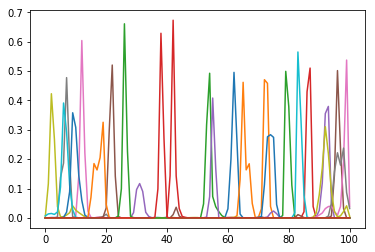

In [113]:
target, inp, mask, x_max = next(iter(dataset))

forecast = inp[:8,:]
blank    = tf.zeros_like(forecast[:,-1:])
forecast = tf.concat([forecast, blank], 1)
for n in range(120-12, 120-2):
    pred = model(forecast[:,-120:], train=False)
    pred = tf.log(tf.nn.softmax(pred[:,n]))
    pred = tf.random.multinomial(pred, 1) / hparams.quantization_channels
    #pred = tf.argmax(pred, -1) / (hparams.quantization_channels + 1)
    pred = tf.reshape(tf.cast(pred, tf.float32), [-1,1,1])
    forecast = tf.concat([forecast[:,:n+1], pred, forecast[:,n+2:]], 1)
    
for n in range(24):
    pred = model(forecast[:,-24*5:], train=False)
    pred = tf.log(tf.nn.softmax(pred[:,-1]))
    plt.plot(np.exp(pred[0]))

    pred = tf.random.multinomial(pred, 1) / hparams.quantization_channels
    #pred = tf.argmax(pred, -1) / (hparams.quantization_channels + 1)
    pred = tf.reshape(tf.cast(pred, tf.float32), [-1,1,1])
    forecast = tf.concat([forecast[:,:-1], pred, blank], 1)
    

plt.show()
    

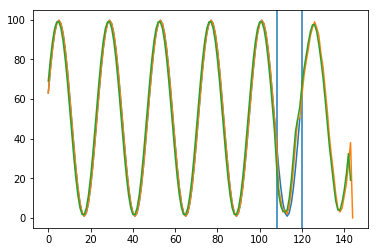

ValueError: zero-size array to reduction operation maximum which has no identity

In [118]:
TARGET = 0
plt.plot(np.squeeze(inp[TARGET,:]) * hparams.quantization_channels)
plt.axvline(x=120-12)
plt.axvline(x=120)
#plt.plot(np.squeeze(np.concatenate([inp[0], inp[129]], axis=0)) * np.max(x_max))

plt.plot(np.squeeze(forecast[TARGET]).T * hparams.quantization_channels)
plt.plot(np.convolve(forecast[TARGET,:,0], [0.5, 0.5])[1:-1] * hparams.quantization_channels)
#plt.plot(np.convolve(forecast[3,:,0], [0.5, 0.5])[1:-1] * np.max(x_max))


plt.show()

pred = model(inp[:TARGET])
pred = tf.reshape(pred, [TARGET, 120-1, -1])
plt.plot(np.squeeze(tf.nn.softmax(pred[0,-10:])).T)
plt.show()
plt.imshow(np.squeeze(tf.nn.softmax(pred))[0].T)
plt.show()

## Test Hyperparameters

In [ ]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model_ = WaveNet(params)
    optimizer_ = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model_, optimizer_, dataset, hparams, epochs = 3, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model_)
    stats.append(stat)

Learning Rate -3.5000 Loss 0.0254 Accuracy 0.0254 Time 32.2
Learning Rate -3.0000 Loss 0.0247 Accuracy 0.0247 Time 31.2
Learning Rate -2.5000 Loss 0.0254 Accuracy 0.0254 Time 31.5

## Test Model Accuracy

In [ ]:
model_accuracy = []

In [ ]:
for name, dataset_eval in([['Train', dataset], ['Test', dataset_test]]):
    print(name + ' Results')
    total_accuracy = []
    x_variance = x_var(hparams, mode=get_fields)

    for i, (inp, target, mask, x_max) in enumerate(dataset_eval):
        forecast = model(inp, mask)

        accuracy = tf.squeeze(forecast - target) * x_max
        accuracy = accuracy ** 2 / x_variance
        accuracy = np.mean(accuracy, axis=0)

        total_accuracy.append(accuracy)

    model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))

    print('Total RSE Accuracy: %.4f' % np.mean(total_accuracy))
    print('Total MSE Accuracy: %.4f' % (np.mean(total_accuracy) * x_variance))
    plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

https://openai.com/blog/better-language-models/

https://github.com/openai/finetune-transformer-lm